In [1]:
import warnings
warnings.filterwarnings('ignore')
import gempy as gp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from gempy.assets import topology as tp
from tqdm import tqdm_notebook
import seaborn as sns
import pandas as pd
from tqdm import tqdm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Geomodel

In [2]:
geo_model1 = gp.create_model('Bregenz')
geo_mode1l = gp.init_data(geo_model1,
                         extent=[556000,574000,5234000,5275000,-6500,1300], #18 km by 41 km
                         resolution=[80,80,50],
                         path_o='modeling_data/or.csv',
                         path_i='modeling_data/surf.csv')

gp.map_stack_to_surfaces(geo_model1,
                        {'Fault_004' : ['Fault_004'],'Fault_003' : ['Fault_003'],'Fault_001' : ['Fault_001'],
                         'Fault_00' : ['Fault_00'],'Fault_2' : ['Fault_2'],'Fault_3' : ['Fault_3'],'Fault_4' : ['Fault_4'],
                         'Fault_5' : ['Fault_5'],'Fault_6' : ['Fault_6'],'Fault_7' : ['Fault_7'],'Fault_8' : ['Fault_8'],
                         'Fault_9' : ['Fault_9'],'sed_series' : ['UFM','UMM','Up_LFM','LFM','LMM','RDF']})

geo_model1.set_is_fault(['Fault_004','Fault_003','Fault_001','Fault_00','Fault_2','Fault_3','Fault_4',
                         'Fault_5','Fault_6','Fault_7','Fault_8','Fault_9'])

geo_model1.surfaces.colors.change_colors({'UFM':'#f2f542', 'UMM':'#917e11',
                                         'Up_LFM':'#ccbd6a','LFM':'#ccbd6a',
                                         'LMM' : '#422902', 'RDF' : '#6ba0bf', 'basement' : '#6ba0bf'})

interp_data = gp.set_interpolator(geo_model1,
                                 compile_theano=True,
                                 theano_optimizer='fast_run', gradient=False, dype='float32')
gp.compute_model(geo_model1)

#gp.plot_3d(geo_model1, show_lith = False, show_data = True, show_results = True)

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  12
Compilation Done!
Kriging values: 
                                                      values
range                                          45451.512626
$C_o$                                       49186666.666667
drift equations  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]



Lithology ids 
  [19.         19.         18.02441994 ... 13.         13.
 13.        ] 

In [34]:
gp.plot_3d(geo_model1, show_lith = False, show_data = True, show_results = True)

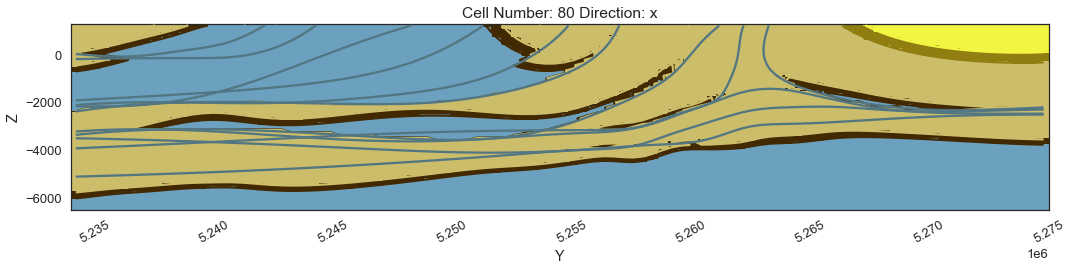

In [29]:
gp.plot_2d(geo_model1, show_data = False, direction = 'x', figsize = (15,8), cell_number = 80)
plt.savefig('section3.svg')

# Adjacency matrix trial

In [3]:
#load stuff and make 
#posterior stuff
edges = np.load('results_data/graphs.npy', allow_pickle=True)
edges2 = np.load('results_data/graphs2.npy', allow_pickle=True)
centroids = np.load('results_data/centroids.npy', allow_pickle=True)
centroids2 = np.load('results_data/centroids2.npy', allow_pickle=True)
edges = np.append(edges, edges2)
centroids = np.append(centroids, centroids2)

#prior stuff
edges_pr = np.load('results_data/graphsprior.npy', allow_pickle=True)
cents_pr = np.load('results_data/centroidsprior.npy', allow_pickle=True)

In [11]:
def AdjMatrix(geo_model, edges, centroids, mode):
    model_df = geo_model.surfaces.df
    surfaces = model_df['surface'].unique()
    
    surface_list = []
    for surf in surfaces:
        if 'fault' in surf: #changes depending on the names given to the faults in the model
            continue
        else:
            surface_list.append(surf)
    surf_df = model_df.query('surface == @surface_list')
    
    lith_ids = tp.get_lith_ids(geo_model)
    lith_count = len(lith_ids)
    fault_ids = tp.get_fault_ids(geo_model)
    fault_count = len(fault_ids)
    
    #create an empty matrix
    lith_matrix = np.ones((fault_count*lith_count, fault_count*lith_count), dtype = int)
    
    adj_matrix = tp.get_adjacency_matrix(geo_model, edges, centroids).astype(np.int)
    
    for i in range(fault_count):
        lith_matrix[i*lith_count:(i+1)*lith_count, i*lith_count:(i+1)*lith_count] = 0
    
    ml = adj_matrix * lith_matrix
    
    if mode == 'Lith':  
        final_matrix = ml
    elif mode == 'Fault':
        final_matrix = adj_matrix - ml
    
    return final_matrix

In [13]:
#Add all the matrices together
lith_ids = tp.get_lith_ids(geo_model1)
lith_count = len(lith_ids)
fault_ids = tp.get_fault_ids(geo_model1)
fault_count = len(fault_ids)

n_iterations = 400

#posterior prob matrix
matrix_liths = np.ones((fault_count*lith_count, fault_count*lith_count), dtype=int)
matrix_faults = np.ones((fault_count*lith_count, fault_count*lith_count), dtype=int)
#prior prob matrix
matrix_liths_pr = np.ones((fault_count*lith_count, fault_count*lith_count), dtype=int)
matrix_faults_pr = np.ones((fault_count*lith_count, fault_count*lith_count), dtype=int)

for i in range(n_iterations):
    matrix_liths += AdjMatrix(geo_model1, edges[i], centroids[i], mode = 'Lith')
    matrix_faults += AdjMatrix(geo_model1, edges[i], centroids[i], mode = 'Fault')
    matrix_liths_pr += AdjMatrix(geo_model1, edges_pr[i], cents_pr[i], mode = 'Lith')
    matrix_faults_pr += AdjMatrix(geo_model1, edges_pr[i], cents_pr[i], mode = 'Fault')    

In [14]:
#get the frequency
matrix_liths = matrix_liths / n_iterations
matrix_faults = matrix_faults / n_iterations
matrix_liths_pr = matrix_liths_pr / n_iterations
matrix_faults_pr = matrix_faults_pr / n_iterations

In [15]:
#now let's plot it

from matplotlib.colors import LinearSegmentedColormap
# create a colormap
cdict = {'red':   ((0.0,  1.0, 1.0),
                   (0.5,  0.01, 0.01),
                   (1.0,  0.01, 0.01)),

         'green': ((0.0, 1.0, 1.0),
                   (0.5, 0.36, 0.36),
                   (1.0, 0.99, 0.99)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.5,  0.98, 0.98),
                   (1.0,  0.96, 0.96)),

         'alpha':  ((0.0,  0.0, 0.0),
                   (0.5,  0.5, 0.5),
                   (1.0,  1.0, 1.0))}

cmap_name = 'entropy_layers'
cm = LinearSegmentedColormap(cmap_name, cdict)
plt.register_cmap(cmap=cm)

cdict2 = {'red':   ((0.0,  1.0, 1.0),
                   (0.5,  0.0, 0.0),
                   (1.0,  0.55, 0.55)),

         'green': ((0.0, 1.0, 1.0),
                   (0.5, 0.52, 0.52),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.5,  0.31, 0.31),
                   (1.0,  0.0, 0.0)),

         'alpha':  ((0.0,  0.0, 0.0),
                   (0.5,  0.7, 0.7),
                   (1.0,  1.0, 1.0))}

cmap_name2 = 'entropy_faults'
cm2 = LinearSegmentedColormap(cmap_name2, cdict2)
plt.register_cmap(cmap=cm2)

In [37]:
import matplotlib.colors as mcolors
def fancymatrix(geo_model, matrix_liths, matrix_faults):
    
    model_df = geo_model.surfaces.df
    strats = model_df['surface'].unique()

    strat_list = []
    for istrat in strats:
        if "Fault" in istrat:
            continue
        else:
            strat_list.append(istrat)
    strat_df = model_df.query('surface == @strat_list')
    
    lith_ids = tp.get_lith_ids(geo_model1)
    liths = len(lith_ids)
    fault_ids = tp.get_fault_ids(geo_model1)
    faults = len(fault_ids)
    
    ### Define styling of figure
    fig_size = 40                               # figuresize in cm
    plot_lith_names = True                      # Turn True/False to either plot names of liths or only their IDs
    plot_fault_segments = True                  # Turn True/False to highlight the different segments of faults
    fault_seg_color = 'black'                     # Color of segmentation line
    cmap = mcolors.ListedColormap(
        list(strat_df['color']))  # Automatic extraction of colors of geomodel

    # check out https://matplotlib.org/stable/tutorials/text/text_props.html for more options to make labels nice

    tick_labels = {
        'family': 'arial',
        'color':  'black',
        'weight': 'bold',
        'size': 11,
        }

    legend_labels = {
        'family': 'calibri',
        'weight': 'bold',
        'size': 20,
        }

    ### Build axes
    fig = plt.figure(figsize=(fig_size/2.54,fig_size/2.54))
    y0 = 0.0    # padding value for rel. distance to bottom
    x0 = 0.0    # padding value for rel. distance to left
    strati_width = 0.03     # scaling value for rel. thickness of colored bars
    box_height = 0.8    # scaling value for rel. width/height of matrix

    vert_ax = fig.add_axes([x0, y0, strati_width, box_height]) # build vertical axes
    hori_ax = fig.add_axes([x0+strati_width, y0+box_height, box_height, strati_width]) # build horizontal axes
    box_ax = fig.add_axes([x0+strati_width, y0,box_height, box_height]) # build matrix axes

    ### Build stack of repeating liths to fill axis
    stratid_stack = np.array([])

    for i in range(faults):
        stratid_stack = np.hstack([stratid_stack, lith_ids])

    ### Build string list with lith names
    df = geo_model1.surfaces.df.set_index('id')
    strat_stack = df['surface'].loc[stratid_stack].values

    # plot colorbars and matrix
    hori_ax.imshow(stratid_stack.reshape(1,-1), origin='upper', aspect='auto', cmap=cmap)
    vert_ax.imshow(stratid_stack.reshape(-1,1), origin='upper', aspect='auto', cmap=cmap)

    box_ax.imshow(matrix_liths, cmap = 'entropy_layers')
    box_ax.imshow(matrix_faults, cmap = 'entropy_faults')
    box_ax.xaxis.tick_top()

    # Style axis
    xticks = box_ax.get_xticklabels()
    yticks = box_ax.get_yticklabels()

    vert_ax.axis('off')
    hori_ax.axis('off')

    box_ax.set_yticklabels([])
    box_ax.set_xticklabels([])

    # Plot fault segments if wanted
    if plot_fault_segments == True:
        pos = liths # length of fault ids
        for i in range(1,faults):
            box_ax.hlines(pos*i-0.5, -0.5, len(stratid_stack)-0.5, lw=0.5, color=fault_seg_color, alpha = 0.5)
            box_ax.vlines(pos*i-0.5, -0.5, len(stratid_stack)-0.5, lw=0.5, color=fault_seg_color, alpha = 0.5)
            vert_ax.hlines(pos*i-0.5, -0.5, 0.5, lw=0.5, color=fault_seg_color, alpha = 0.5)
            hori_ax.vlines(pos*i-0.5, -0.5, 0.5, lw=0.5, color=fault_seg_color, alpha = 0.5)

    for istrat in strat_list:
        print(istrat)
        sub_df = strat_df.query('surface == @istrat')

        box_ax.scatter([],[], marker='s', label=istrat, color=sub_df['color'].iloc[0])

    plt.sca(box_ax)

    plt.rc('legend', fontsize=legend_labels['size'])
    plt.legend(loc='lower left',ncol=1, frameon=True, prop=legend_labels, 
               framealpha=1.0, facecolor="#D9DEDA", edgecolor='black',
              fancybox=True)
    plt.show()

    plt.savefig('matrix.svg')

UFM
UMM
Up_LFM
LFM
LMM
RDF
basement


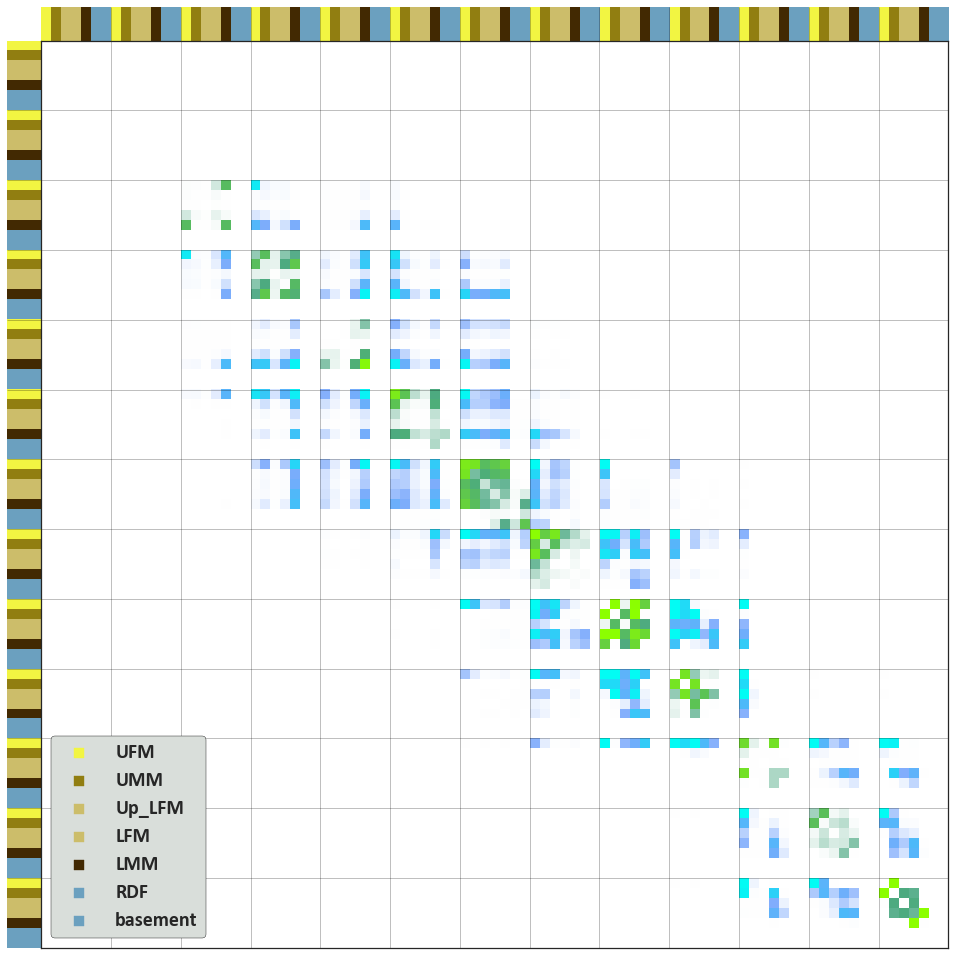

<Figure size 432x288 with 0 Axes>

In [38]:
fancymatrix(geo_model1, matrix_liths, matrix_faults)

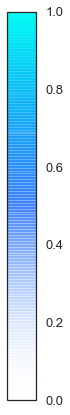

In [40]:
#colorbar
import pylab as pl

a = np.array([[0,1]])
pl.figure(figsize=(0.5,9))
img = pl.imshow(a, cmap="entropy_layers")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="vertical", cax=cax)
pl.savefig("layers.svg")

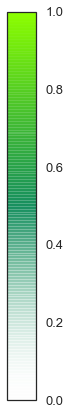

In [41]:
import pylab as pl

a = np.array([[0,1]])
pl.figure(figsize=(0.5,9))
img = pl.imshow(a, cmap="entropy_faults")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="vertical", cax=cax)
pl.savefig("faults.svg")